# 針對多個分類器對於餐廳評論類別之準確度比較

**組別:** 第五組<br>
**組長:** B084020018林昱震<br>
**組員:** B084020009程尤欣、B084020031劉杰煊、B084020035姚昀誠<br>
**分工:** 
    <ul>
        <li>資料搜集、分析：程尤欣、林昱震、劉杰煊</li>
        <li>統整、報告：姚昀誠</li>
    <ul/>


**Demo網址:** https://youtu.be/tm4_AqZ20Fs

## 大綱
1. 動機與分析目的
2. 資料集說明
3. 資料分析過程與結果說明
4. 結論


## 1. 動機與分析目的
觀察Google map 的評論欄位可以發現，現在Google map有新增了一些可以直接對餐廳的各項指標進行評分的功能。於是我們想嘗試看看，使用課堂中所學習到的分類技術，是否能夠直接從使用者的評論中萃取出其在描述的評論。

流程如下：
首先，使用 Word2Vec 模型，分析資料集中字詞與各個餐廳類別的相似度等，再利用課程所學之分類器，包括監督式學習之邏輯斯回歸、非監督式學習之 Guided LDA 主題模型，並使用已標注完成，內含五個不同餐廳類別的訓練資料，來對其做分類並比較兩分類器其中的差異。

## 2. 資料集說明

本資料集爬取了 google map 上針對餐廳的各種評論，其中含有五個餐廳類別，分別是食物、價格、服務、環境及交通。

### 2.1 引入套件

In [ ]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

### 2.2 資料集

In [ ]:
comment = pd.read_csv("restaurant.csv")  # 匯資料
comment.head(3)

,comment,category
0,非常難找車位,5
1,好吃好喝好讚,1
2,經濟實惠,4


In [ ]:
# 看看有幾個類別
print(f"number of posts: {comment.shape[0]}")
print(f"category: \n{comment['category'].value_counts()}")


number of posts: 1727
category: 
category
3    409
2    373
4    336
5    306
1    303
Name: count, dtype: int64


這邊的數字代表的類別如下：<br>
    1:食物
    2:環境
    3:服務
    4:價格
    5:交通

## 3. 資料分析過程與結果說明

### 3.1 資料前處理

#### 3.1.1 清理

In [ ]:
# 只留下中文字
comment["comment"] = comment.comment.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
comment.head(3)

,comment,category
0,非常難找車位,5
1,好吃好喝好讚,1
2,經濟實惠,4


In [ ]:
# 看看有幾則評論
print(f"total docs: {comment.shape[0]}")


total docs: 1727


#### 3.1.2 斷詞

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [ ]:
comment["words"] = comment["comment"].apply(getToken).map(" ".join)
comment.head()

Building prefix dict from c:\Users\USER\Downloads\final_project\dict\dict.txt.big ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.u580261f80af1273d818be2c1170f5618.cache
Loading model cost 1.496 seconds.
Prefix dict has been built successfully.


,comment,category,words
0,非常難找車位,5,車位
1,好吃好喝好讚,1,好吃好喝
2,經濟實惠,4,經濟 實惠
3,店由一對老夫婦經營很親切慈祥,3,一對 夫婦 經營 親切 慈祥
4,價格實惠,4,價格 實惠


### 3.2 利用 Word2Vec 模型分析字詞

In [ ]:
# 移除網址格式
# 只留下中文字
comment["comment"] = comment["comment"].str.replace("(http|https)://.*", "", regex=True)
comment["comment"] = comment["comment"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
comment['content'] = comment['comment']
comment.head(3)

,comment,category,content
0,非常難找車位,5,非常難找車位
1,好吃好喝好讚,1,好吃好喝好讚
2,經濟實惠,4,經濟實惠


建立bigram

In [ ]:
sents = comment['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
comment['word_list_bigrams'] = list(bigram_phrasers[sents])

comment.head()

,comment,category,content,word,word_list_bigrams
0,非常難找車位,5,非常難找車位,"[難找, 車位]","[難找, 車位]"
1,好吃好喝好讚,1,好吃好喝好讚,"[好吃, 好喝]","[好吃, 好喝]"
2,經濟實惠,4,經濟實惠,"[經濟, 實惠]","[經濟, 實惠]"
3,店由一對老夫婦經營很親切慈祥,3,店由一對老夫婦經營很親切慈祥,"[夫婦, 經營, 親切, 慈祥]","[夫婦, 經營, 親切, 慈祥]"
4,價格實惠,4,價格實惠,"[價格, 實惠]","[價格, 實惠]"


In [ ]:
word_freq = defaultdict(int)
# 計算詞頻
sents = comment['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [ ]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 2042


['餐廳', '提供', '服務', '價格', '交通', '方便', '美味', '用餐', '附近', '服務員']

In [ ]:
print(f"sentence number of corpus: {len(sents)}")
i= 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 1727
average length of sentences: 7.903879559930515


Word2Vec 計算

In [ ]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [ ]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 16


In [ ]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=5,# 小於15次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                    #  negative=20,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax 
                     )

查看結果

In [ ]:
w2v_model.wv.index_to_key

['餐廳',
 '提供',
 '服務',
 '價格',
 '交通',
 '方便',
 '美味',
 '用餐',
 '附近',
 '服務員',
 '菜單',
 '環境',
 '選擇',
 '關注',
 '需求',
 '能夠',
 '搭配',
 '適合',
 '到達',
 '態度',
 '口感',
 '便利',
 '充滿',
 '有多個',
 '每道',
 '保持',
 '美食',
 '前往',
 '豐富',
 '水平',
 '地鐵站',
 '感到',
 '風味',
 '公車站',
 '詳細',
 '獨特',
 '味道',
 '客人',
 '確保',
 '市場',
 '平均',
 '顧客',
 '相對',
 '印度',
 '位於',
 '口味',
 '亞洲',
 '位置',
 '美式',
 '食物',
 '海鮮',
 '多汁',
 '始終',
 '人員',
 '開車',
 '停車場',
 '快捷',
 '泰式',
 '新鮮',
 '菜品',
 '乘坐',
 '建議',
 '所在地',
 '韓國',
 '越南',
 '喜歡',
 '鮮美',
 '體驗',
 '舒適',
 '香濃',
 '合理',
 '步行',
 '靠近',
 '點餐',
 '優質',
 '飲料',
 '日式',
 '多種',
 '無法',
 '感覺',
 '停車',
 '區域',
 '繁忙',
 '友善',
 '希望',
 '線路',
 '願意',
 '略高',
 '精緻',
 '酥脆',
 '濃郁',
 '滿意',
 '中東',
 '給出',
 '享受',
 '方式',
 '公共',
 '裝潢',
 '質量',
 '薯條',
 '石鍋',
 '香氣',
 '鮮嫩',
 '解釋',
 '特別',
 '多樣',
 '出行',
 '河粉',
 '燒肉',
 '奶酪',
 '可口',
 '需要',
 '改進',
 '效率',
 '春捲',
 '有多條',
 '素食',
 '這種',
 '墨西哥',
 '一種',
 '不錯',
 '搭乘',
 '氛圍',
 '小吃',
 '周圍',
 '滿足',
 '停車位',
 '再次',
 '四溢',
 '檸檬草',
 '設計',
 '總是',
 '期間',
 '了解',
 '光顧',
 '周邊',
 '工具',
 '乾淨',
 '食材',
 '醬汁',
 '風格',
 '茶

In [ ]:
len(w2v_model.wv.index_to_key)

487

In [ ]:
# 檢查與餐廳最相關的字
w2v_model.wv.most_similar('餐廳',topn=10)

[('感到', 0.9656776189804077),
 ('美食', 0.9648609757423401),
 ('味道', 0.9611204862594604),
 ('享受', 0.9589782357215881),
 ('出行', 0.954940676689148),
 ('能夠', 0.9543809294700623),
 ('滿意', 0.9537007212638855),
 ('豐富', 0.9536730647087097),
 ('地鐵', 0.9528008103370667),
 ('鮮美', 0.9518492817878723)]

從上述最相關的幾個詞可以發現，餐廳菜品的味道可能很濃郁、很美味

In [ ]:
w2v_model.wv.most_similar('服務員',topn=10)

[('介紹', 0.9463949203491211),
 ('服務', 0.940596342086792),
 ('食物', 0.9387892484664917),
 ('滿意', 0.928252100944519),
 ('願意', 0.9250775575637817),
 ('搭配', 0.924535870552063),
 ('質量', 0.9229359030723572),
 ('無法', 0.9224014282226562),
 ('快速', 0.922343909740448),
 ('點餐', 0.9220955967903137)]

In [ ]:
w2v_model.wv.most_similar(['食物','餐廳'],topn=10)

[('滿意', 0.9816036224365234),
 ('搭配', 0.9787779450416565),
 ('味道', 0.9760738611221313),
 ('無法', 0.9747391939163208),
 ('介紹', 0.9731877446174622),
 ('美食', 0.9725521206855774),
 ('風味', 0.971754252910614),
 ('給出', 0.9708048105239868),
 ('享受', 0.9705187678337097),
 ('多樣', 0.9694408774375916)]

In [ ]:
w2v_model.wv.most_similar(negative=['食物','餐廳'],topn=10)

[('熱辣', 0.5617437958717346),
 ('適時', 0.4508163034915924),
 ('戶外', 0.3707783818244934),
 ('綿密', 0.3341144919395447),
 ('麵包', 0.32260408997535706),
 ('最愛', 0.25949424505233765),
 ('消費', 0.2355053573846817),
 ('優質', 0.21930094063282013),
 ('空間', 0.15363280475139618),
 ('滑順', 0.1315111368894577)]

In [ ]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("食物","薯條")

0.76567054

In [ ]:
w2v_model.wv.similarity("口感","香氣")

0.96042633

In [ ]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["口感", "香氣", '交通'])

'交通'

In [ ]:
# 相對關係
w2v_model.wv.most_similar(positive=["交通", "口感"], negative=["香氣"], topn=5)

[('地鐵', 0.946679413318634),
 ('附近', 0.9350826740264893),
 ('乘坐', 0.9337024092674255),
 ('適合', 0.9332165122032166),
 ('公車站', 0.929133951663971)]

In [ ]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字的關係及將自分群

In [ ]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSEN":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)
    
    
    return new_feat


In [ ]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)
    

In [ ]:
getVecs(w2v_model,['餐廳','美食'])

array([[ 0.04323468,  0.06242664, -0.08589969,  0.14570704,  0.16863132,
        -0.06608225,  0.09523082,  0.01786578, -0.03549938,  0.0235136 ,
         0.04440337, -0.12090267, -0.07403934, -0.07734475, -0.04122896,
         0.16628473,  0.17604773,  0.01681481, -0.01603586,  0.01765305,
         0.00464056, -0.04419046,  0.12641838,  0.05898429, -0.02879184,
         0.22714598,  0.10257729,  0.09605391,  0.06810653, -0.02315225,
         0.03354233,  0.09978459, -0.1619299 ,  0.1201715 , -0.04623026,
        -0.06432062,  0.02441121, -0.06636015, -0.06949854, -0.02183722,
         0.00642283, -0.10477409, -0.07318803,  0.08995767, -0.08610721,
        -0.02786082, -0.04272424,  0.1293939 ,  0.03719302, -0.08550524,
         0.26172462,  0.0182867 , -0.15387802,  0.10993215, -0.07636546,
        -0.10245965, -0.12702863, -0.12995479, -0.02770593, -0.04707109,
        -0.00073631,  0.08094005, -0.02048246,  0.10868005, -0.01592297,
        -0.05213282,  0.08337396,  0.01017221,  0.1

In [ ]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):
    
    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []
    
    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [ ]:
expandPosWord(w2v_model,['餐廳','食物'],top_n = 10)

['願意',
 '感到',
 '中東',
 '期間',
 '滿意',
 '能夠',
 '鮮美',
 '建議',
 '搭配',
 '味道',
 '豐富',
 '出行',
 '無法',
 '美食',
 '享受',
 '客人',
 '介紹',
 '給出',
 '地鐵']

In [ ]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'
    
    p = sns.scatterplot(x="dim1", y="dim2", 
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [ ]:
sample_words = np.random.choice(list(words),50,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSEN',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(50, 128)
(50, 2)


In [ ]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1], 
})

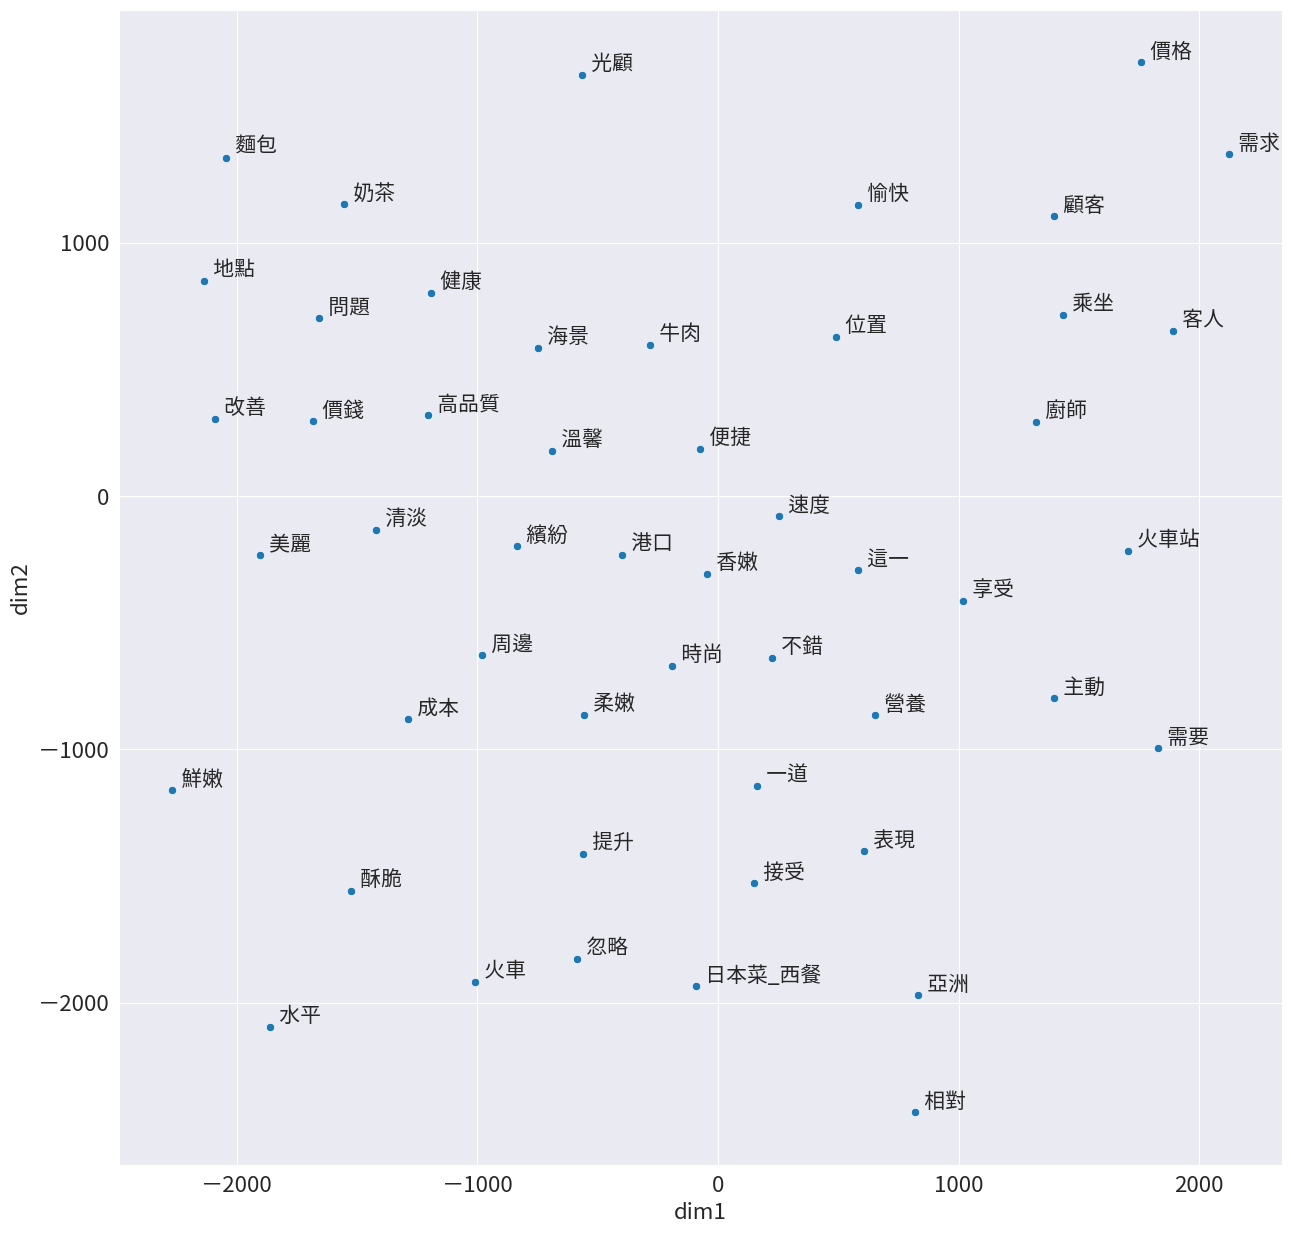

In [ ]:
plotScatter(word_df)

In [ ]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2], 
})
plotScatter3D(word_df)

(50, 3)


In [ ]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):
    
    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [ ]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=5),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1], 
    "dim3":d3_feat[:,2], 

})
plotScatter3D(word_df)


c:\Users\a0958\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### 3.2 利用 Logistic Regression 進行餐廳類別的分類

#### 3.2.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [ ]:
data = comment
X = data["words"]
y = data["category"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

1520       包坊 口感 鬆軟 香氣 四溢 每一款 令人 垂涎欲滴
796            餐廳 佈局合理 給人 一種 舒適 用餐 體驗
1541        北京烤鴨 皮脆 搭配 薄餅 蔥絲 口感 獨特 美味
591                   甜點 先行 解凍 直接 送上來
1666    餐廳 距離 港口 很近 乘船 到達 享受 海上 旅行 樂趣
Name: words, dtype: object
1520    1
796     2
1541    1
591     1
1666    5
Name: category, dtype: int64


In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['category'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
category
3    23.682687
2    21.598147
4    19.455704
5    17.718587
1    17.544876
Name: proportion, dtype: float64

train percentage :
category
3    23.509934
2    21.771523
4    20.115894
1    17.963576
5    16.639073
Name: proportion, dtype: float64

test percentage :
category
3    24.084778
2    21.194605
5    20.231214
4    17.919075
1    16.570328
Name: proportion, dtype: float64


#### 3.2.2 將文章轉為 DTM

在這裡我們用簡單的四個中文句子，建立一個 DTM，在這裡我們利用 `CountVectorizer` 計算出不同句子的詞頻，再轉換成DTM。DTM裡面每個row代表一個句子，每個column代表一個詞出現的次數。

#### 3.2.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [ ]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [ ]:
X_train.head()

1520       包坊 口感 鬆軟 香氣 四溢 每一款 令人 垂涎欲滴
796            餐廳 佈局合理 給人 一種 舒適 用餐 體驗
1541        北京烤鴨 皮脆 搭配 薄餅 蔥絲 口感 獨特 美味
591                   甜點 先行 解凍 直接 送上來
1666    餐廳 距離 港口 很近 乘船 到達 享受 海上 旅行 樂趣
Name: words, dtype: object

In [ ]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<1208x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 8413 stored elements in Compressed Sparse Row format>

In [ ]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一些']

{'口感': 179, '鬆軟': 987, '香氣': 970, '四溢': 214, '令人': 74, '垂涎欲滴': 235, '餐廳': 961, '給人': 656, '一種': 13, '舒適': 713, '用餐': 607, '體驗': 982, '北京烤鴨': 160, '皮脆': 611, '搭配': 413, '薄餅': 753, '獨特': 595, '美味': 672, '甜點': 604, '先行': 114, '解凍': 793, '直接': 614, '送上來': 881, '距離': 851, '港口': 531, '很近': 368, '乘船': 56, '到達': 150, '享受': 67, '海上': 514, '旅行': 440, '樂趣': 480, '風格': 951, '角落': 792, '充滿': 112, '驚喜': 980, '細節': 651, '服務員': 463, '菜單': 739, '食物': 954, '了解': 58, '有限': 459, '無法': 566, '給出': 657, '詳細': 808, '解釋': 797, '客人': 306, '需求': 934, '缺乏': 668, '關注': 921, '需要': 935, '提醒': 411, '得到': 369, '服務': 462, '服務質量': 467, '符合': 630, '這家': 882, '水準': 496, '希望': 341, '能夠': 697, '提升': 410, '客戶': 307, '改進': 420, '環境': 598, '舒服': 710, '意大利': 384, '比薩': 488, '薄脆': 752, '餅皮': 960, '配料': 902, '一口': 4, '點餐': 999, '順序': 941, '錯誤': 913, '繁忙': 666, '效率': 422, '快速': 376, '帶來': 344, '接受': 406, '期間': 468, '忽略': 378, '提供': 409, '適時': 897, '一點': 19, '全面': 124, '整體而言': 428, '這是': 883, '一家': 6, '尚可': 328, '阿拉伯': 922, '酒吧': 9

1

In [ ]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)


(1208, 1000)
(519, 1000)


In [ ]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [ ]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

[5 3 4 4 2 3 3 3 2 3]


In [ ]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(519, 5)


array([2.31926095e-04, 4.28532478e-04, 3.27069467e-04, 2.09625560e-04,
       9.98802846e-01])

In [ ]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.96      0.85      0.90        86
           2       0.71      0.97      0.82       110
           3       0.97      0.83      0.90       125
           4       0.99      0.90      0.94        93
           5       1.00      0.95      0.98       105

    accuracy                           0.90       519
   macro avg       0.93      0.90      0.91       519
weighted avg       0.92      0.90      0.91       519



In [ ]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 73,  12,   0,   1,   0],
       [  1, 107,   2,   0,   0],
       [  1,  20, 104,   0,   0],
       [  1,   8,   0,  84,   0],
       [  0,   4,   1,   0, 100]], dtype=int64)

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '5')])

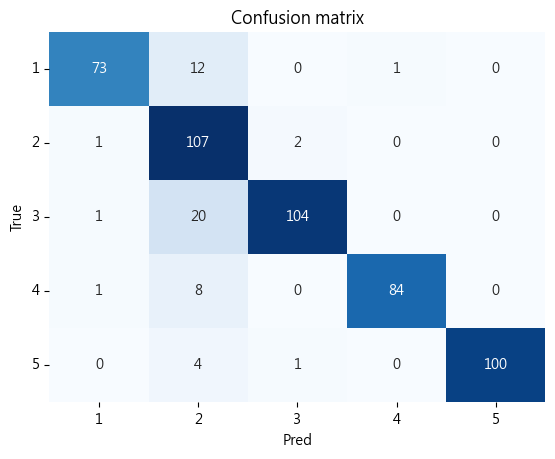

In [ ]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

In [ ]:
# one-hot encoding
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
print(y_onehot_test.shape)  # (n_samples, n_classes)
y_onehot_test[0,:]

(519, 5)


array([0, 0, 0, 0, 1])

In [ ]:
y_test.iloc[0]

5

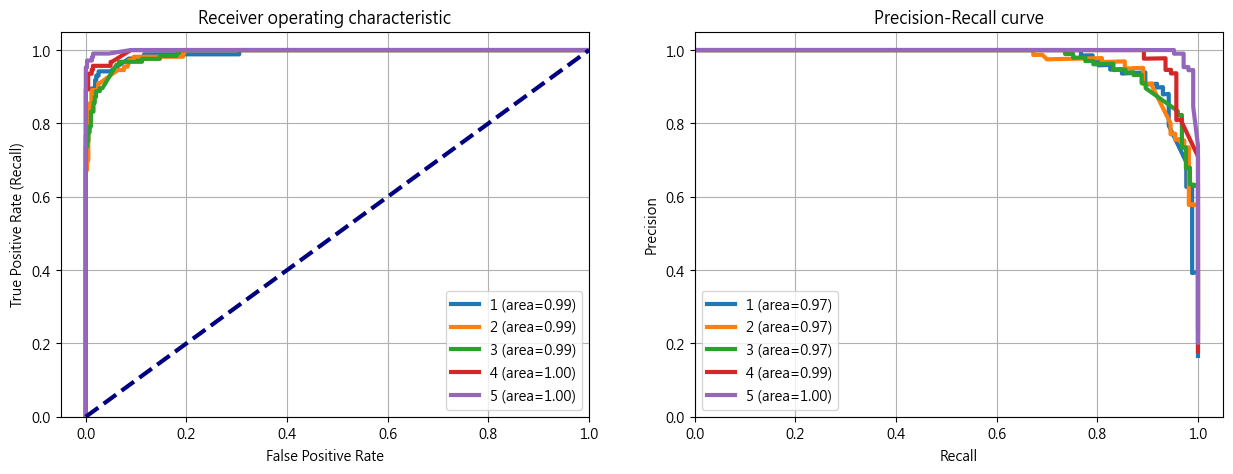

In [ ]:
# plot ROC curve and precision-recall curve
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
    ax[0].plot(
        fpr, tpr, lw=3, label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr))
    )
ax[0].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
ax[0].set(
    xlim=[-0.05, 1.0],
    ylim=[0.0, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate (Recall)",
    title="Receiver operating characteristic",
)
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(
        y_onehot_test[:, i], y_pred_proba[:, i]
    )
    ax[1].plot(
        recall,
        precision,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
    )
ax[1].set(
    xlim=[0.0, 1.05],
    ylim=[0.0, 1.05],
    xlabel="Recall",
    ylabel="Precision",
    title="Precision-Recall curve",
)
ax[1].legend(loc="best")
ax[1].grid(True)

plt.show()


#### 3.2.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.35910

In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.91      0.91      0.91        86
           2       0.76      0.94      0.84       110
           3       0.94      0.82      0.88       125
           4       0.98      0.91      0.94        93
           5       0.99      0.95      0.97       105

    accuracy                           0.90       519
   macro avg       0.92      0.91      0.91       519
weighted avg       0.91      0.90      0.91       519



效果一樣也是不錯，可能因為評論類別本來就有很大的差異，用字遣詞會不同。

#### 3.2.5 CV

In [ ]:
clf = LogisticRegression()
vec_train = CountVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.03787446, 0.04883695, 0.0408597 , 0.0308969 , 0.0308969 ]),
 'score_time': array([0.00298929, 0.00299025, 0.00299072, 0.00399208, 0.00299215]),
 'test_f1_macro': array([0.91130524, 0.86604005, 0.91528783, 0.91376816, 0.88633478]),
 'test_precision_macro': array([0.92743222, 0.90225246, 0.92329115, 0.9269123 , 0.91089995]),
 'test_recall_macro': array([0.90454032, 0.85582266, 0.91167695, 0.90863131, 0.87721313])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [ ]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.84      0.90       217
           2       0.71      0.95      0.81       263
           3       0.91      0.87      0.89       284
           4       0.99      0.85      0.91       243
           5       1.00      0.95      0.97       201

    accuracy                           0.89      1208
   macro avg       0.92      0.89      0.90      1208
weighted avg       0.91      0.89      0.89      1208



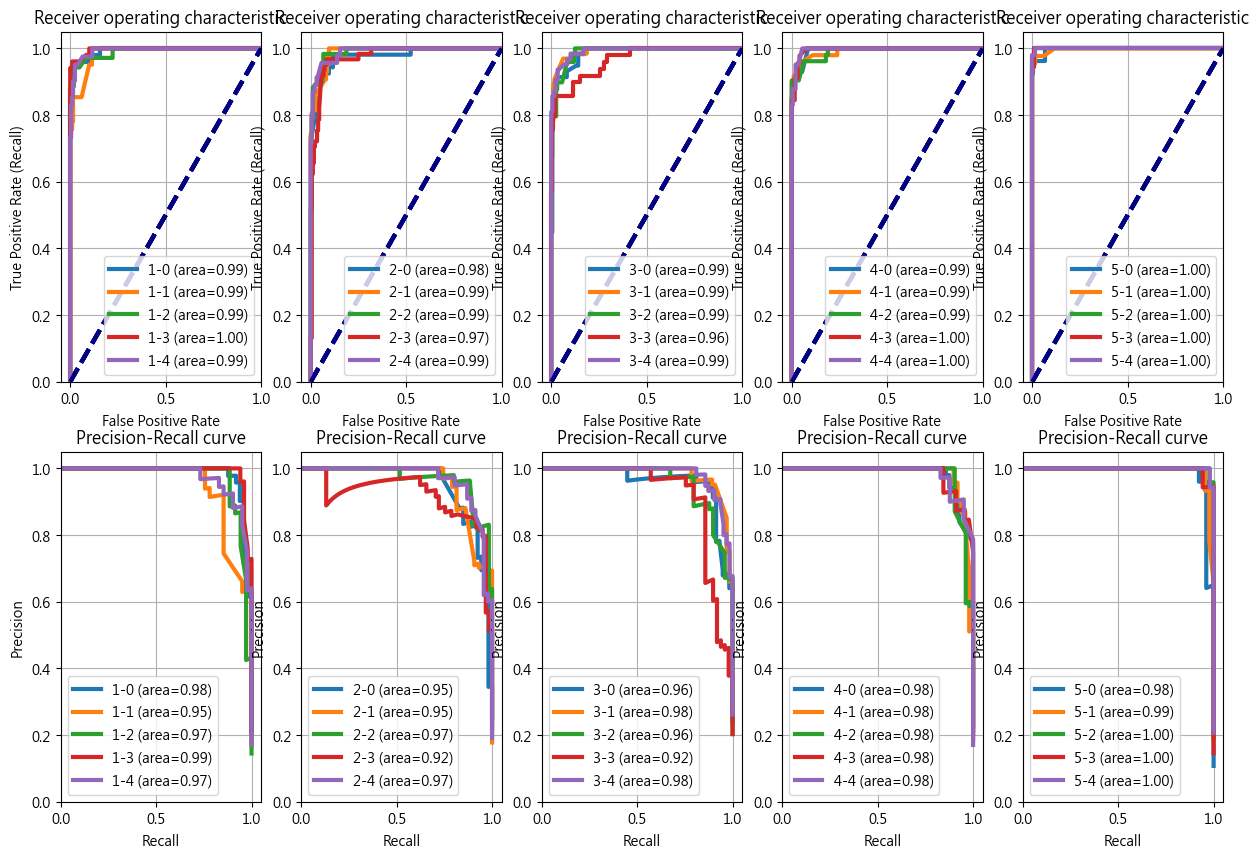

In [ ]:
## 將三個新聞類別的 ROC curve 分別畫出來，並在同一張圖上比較不同 fold 的結果
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
kf = KFold(n_splits=5)
classes = scores['estimator'][0].classes_

for k, (train, test) in enumerate(kf.split(vec_train, y_train)):
    clf.fit(vec_train[train,:], y_train.iloc[train])
    y_pred = clf.predict(vec_train[test,:])    
    y_test = y_train.iloc[test]
    y_pred_proba = clf.predict_proba(vec_train[test,:])
    y_onehot_test = label_binarizer.transform(y_test)        
    

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0,i].plot(
            fpr,
            tpr,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k, auc(fpr, tpr)),
        )
        ax[0,i].plot([0, 1], [0, 1], color="navy", lw=3, linestyle="--")
        ax[0,i].set(
            xlim=[-0.05, 1.0],
            ylim=[0.0, 1.05],
            xlabel="False Positive Rate",
            ylabel="True Positive Rate (Recall)",
            title="Receiver operating characteristic",
        )
        ax[0,i].legend(loc="best")
        ax[0,i].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1,i].plot(
            recall,
            precision,
            lw=3,
            label="{0}-{1} (area={2:0.2f})".format(classes[i], k,auc(recall, precision)),
        )
        ax[1,i].set(
            xlim=[0.0, 1.05],
            ylim=[0.0, 1.05],
            xlabel="Recall",
            ylabel="Precision",
            title="Precision-Recall curve",
        )
        ax[1,i].legend(loc="best")
        ax[1,i].grid(True)

plt.show()

#### 3.2.6 分析可解釋模型的結果(Logistic Regression)

In [ ]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + str(label) + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("Word Frequency", size=14)

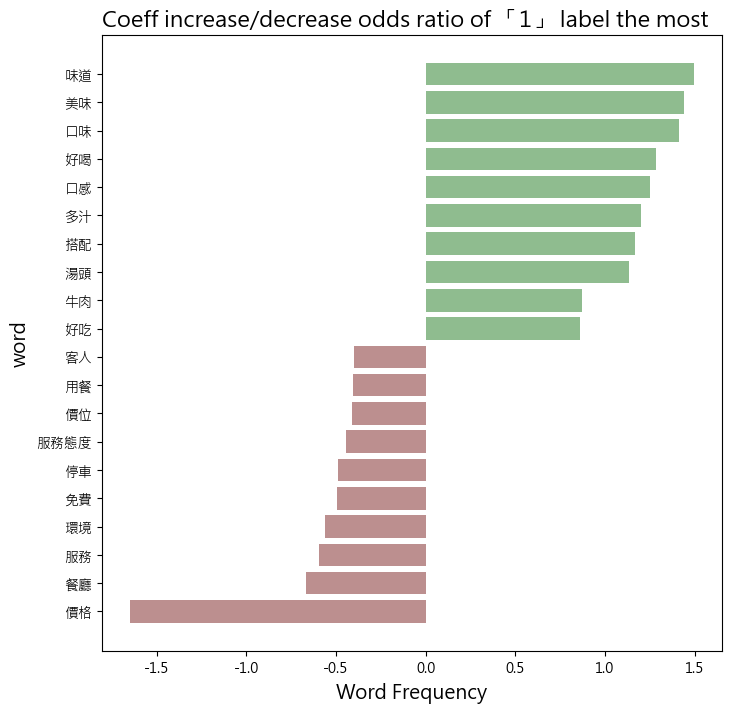

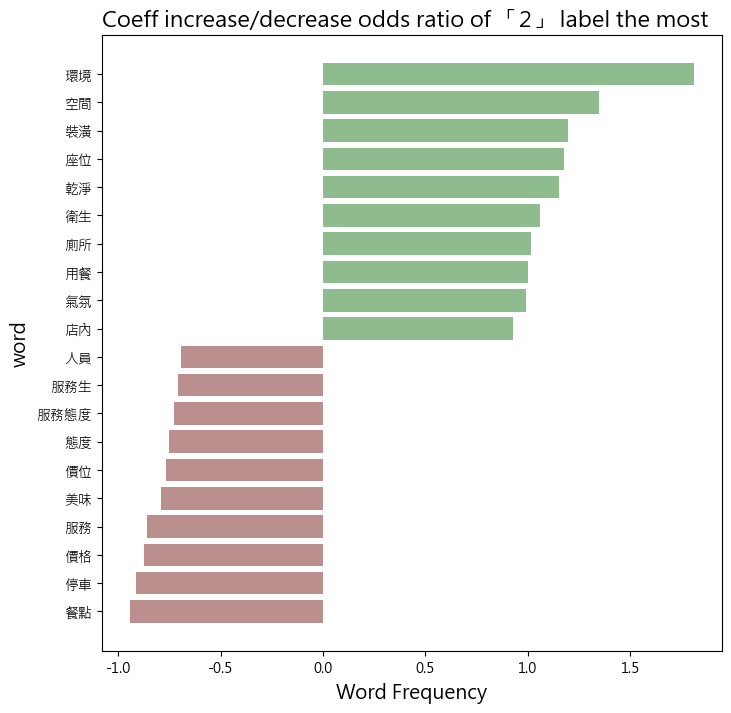

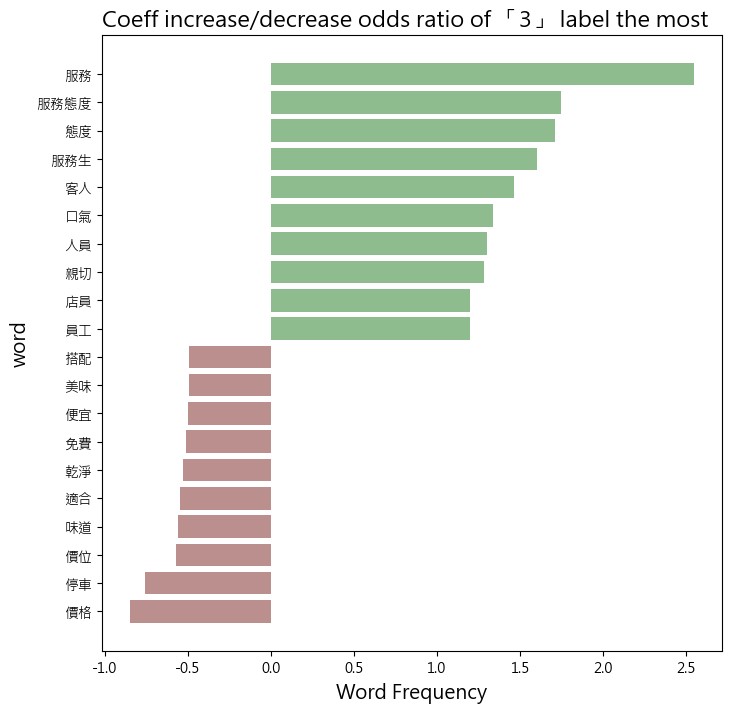

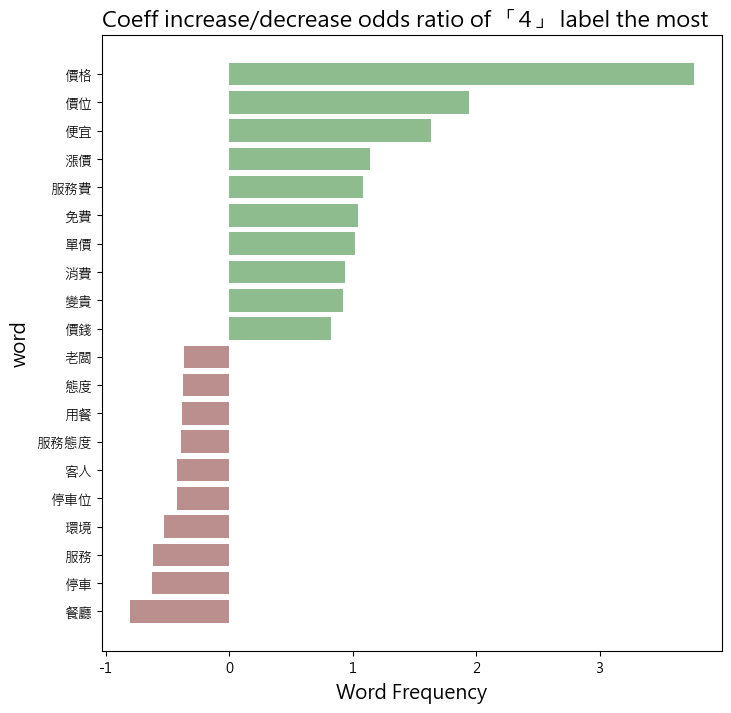

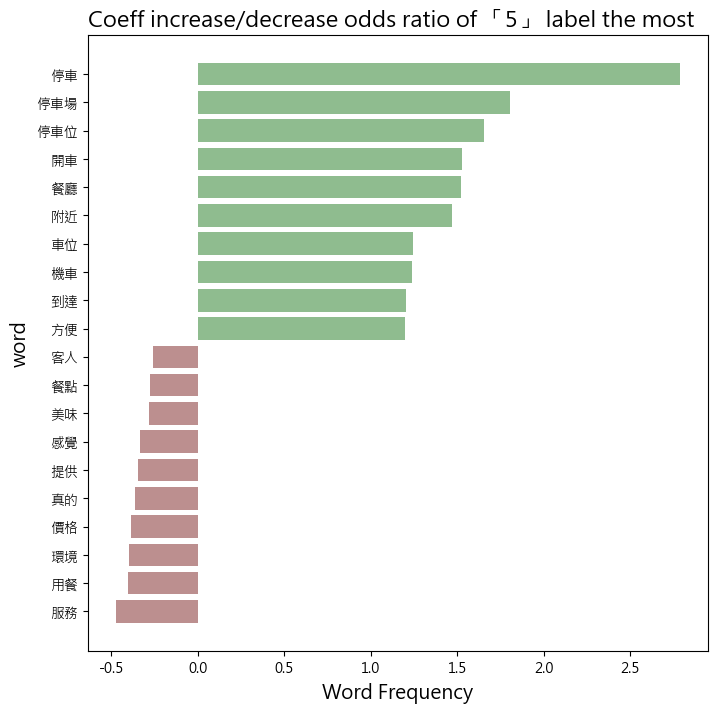

In [ ]:
plot_coef(logistic_reg_model=model_set[best_model_name], feature_names=vectorizer.get_feature_names_out(), top_n=10)

各類別的關鍵字都還蠻合理的，「食物」類別方面都是味道相關的，「環境」類別就是和環境、裝潢相關，「服務」類別圍繞在服務上，「價格」類別就有很多關於價位的詞，「交通」則和停車有很大的關係。

In [ ]:
# 定義模型訓練組合
## 不做 cross validation, 用 test data 來評估模型的版本
## pipeline: 資料處理 vectorizer + 分類器
def train(vectorizer, clf, X_train, y_train, X_test, y_test):

    ## train classifier
    vec_train = vectorizer.fit_transform(X_train).toarray()
    vec_test = vectorizer.transform(X_test).toarray()
    clf.fit(vec_train, y_train)
    

    ## test classifier
    y_pred = clf.predict(vec_test)
    y_pred_proba = clf.predict_proba(vec_test)

    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    ## Accuracy, Precision, Recall, F1-score
    print(classification_report(y_test, y_pred))

    classes = clf.classes_
    ## Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title="Confusion matrix",
    )
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_onehot_test[:, i], y_pred_proba[:, i])
        ax[0].plot(
            fpr,
            tpr,
            lw=3,
            label="{0} (area={1:0.2f})".format(classes[i], auc(fpr, tpr)),
        )
    ax[0].plot([0, 1], [0, 1], color="navy", lw=5, linestyle="--")
    ax[0].set(
        xlim=[-0.05, 1.0],
        ylim=[0.0, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate (Recall)",
        title="Receiver operating characteristic",
    )
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
            y_onehot_test[:, i], y_pred_proba[:, i]
        )
        ax[1].plot(
            recall,
            precision,
            lw=5,
            label="{0} (area={1:0.2f})".format(classes[i], auc(recall, precision)),
        )
    ax[1].set(
        xlim=[0.0, 1.05],
        ylim=[0.0, 1.05],
        xlabel="Recall",
        ylabel="Precision",
        title="Precision-Recall curve",
    )
    ax[1].legend(loc="best")
    ax[1].grid(True)

    plt.show()

    # return the model object
    return classification_report(y_test, y_pred, output_dict=True)


              precision    recall  f1-score   support

           1       0.96      0.85      0.90        86
           2       0.71      0.97      0.82       110
           3       0.97      0.83      0.90       125
           4       0.99      0.90      0.94        93
           5       1.00      0.95      0.98       105

    accuracy                           0.90       519
   macro avg       0.93      0.90      0.91       519
weighted avg       0.92      0.90      0.91       519



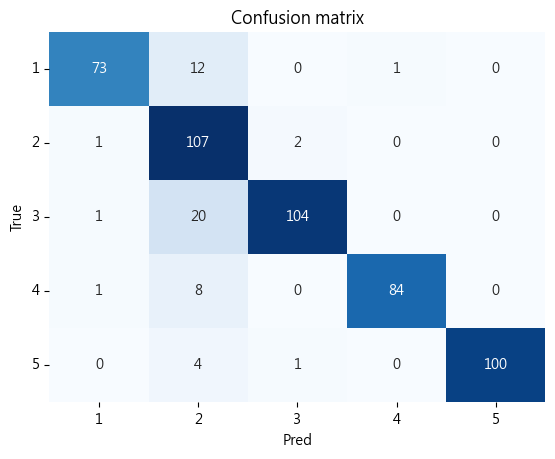

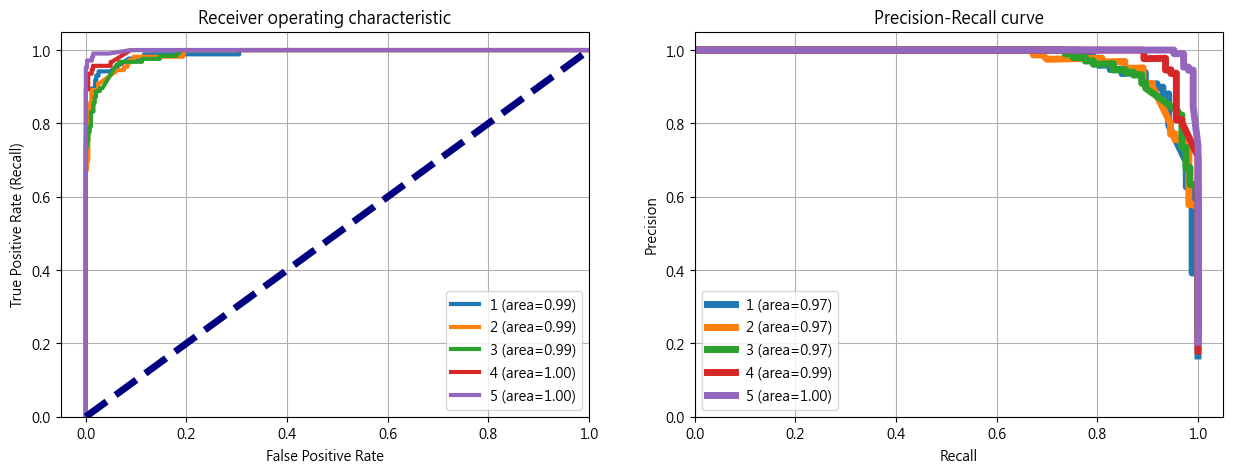

{'1': {'precision': 0.9605263157894737,
  'recall': 0.8488372093023255,
  'f1-score': 0.9012345679012346,
  'support': 86},
 '2': {'precision': 0.7086092715231788,
  'recall': 0.9727272727272728,
  'f1-score': 0.8199233716475095,
  'support': 110},
 '3': {'precision': 0.9719626168224299,
  'recall': 0.832,
  'f1-score': 0.896551724137931,
  'support': 125},
 '4': {'precision': 0.9882352941176471,
  'recall': 0.9032258064516129,
  'f1-score': 0.943820224719101,
  'support': 93},
 '5': {'precision': 1.0,
  'recall': 0.9523809523809523,
  'f1-score': 0.975609756097561,
  'support': 105},
 'accuracy': 0.9017341040462428,
 'macro avg': {'precision': 0.9258666996505459,
  'recall': 0.9018342481724326,
  'f1-score': 0.9074279289006674,
  'support': 519},
 'weighted avg': {'precision': 0.922839099193043,
  'recall': 0.9017341040462428,
  'f1-score': 0.9055510877207975,
  'support': 519}}

In [ ]:
data = udn
X = data["words"]
y = data["category"]
# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
train(vectorizer, clf, X_train, y_train, X_test, y_test)

### 3.3 Guided LDA 進行主題分群

In [ ]:
docs = comment['words'].to_list()
docs

[['車位'],
 ['好吃好喝'],
 ['經濟', '實惠'],
 ['一對', '夫婦', '經營', '親切', '慈祥'],
 ['價格', '實惠'],
 ['用餐', '時間', '門口', '附近', '很好', '停車'],
 ['便宜', '普通'],
 ['價格', '品質', '優質'],
 ['店家', '老闆娘', '親切'],
 ['東西', '便宜'],
 ['兩三年', '漲價'],
 ['免費', '清湯'],
 ['乾淨', '39', '老店'],
 ['感覺', '乾淨'],
 ['黑輪', '特殊', '燒味'],
 ['大腸', '相當', '可口'],
 ['價格便宜'],
 ['黑輪', '湯是', '免費'],
 ['外圍', '停車位'],
 ['價錢', '親民'],
 ['廉價', '供應'],
 ['便宜'],
 ['值得', '推薦', '仔內', '銅板', '美食'],
 ['Cp', '真的'],
 ['喝湯', '免費'],
 ['煮熟', '硬度'],
 ['價位', '實在'],
 ['飲料', '好喝'],
 ['湯頭'],
 ['食材', '搭配', '恰到好處'],
 ['服務', '親切'],
 ['CP', '爆表'],
 ['白蘿蔔', '湯頭', '鮮甜', '好喝'],
 ['蚊子', '真的', '太多'],
 ['建議', '老闆', '處理', '環境'],
 ['漸漸', '漲價'],
 ['平價'],
 ['不好', '待客之道'],
 ['廁所', '不外借'],
 ['業主', '不在乎'],
 ['衛生', '乾淨'],
 ['很好'],
 ['停車'],
 ['老闆', '親切'],
 ['老闆', '不耐煩'],
 ['蚊子', '多了點'],
 ['老闆娘', '親切'],
 ['東西', '平價'],
 ['老闆', '親切', '待人'],
 ['食物', '品項'],
 ['店內', '環境', '乾淨'],
 ['出菜', '稍慢'],
 ['餐點', '符合', '價錢'],
 ['服務生', '忘記', '拖拖拉拉'],
 ['生魚片', '端上來', '真的', '傻眼', '一盤', '要價', '600'],
 ['送餐', '速度慢']

In [ ]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-06-10 23:42:20,168 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-06-10 23:42:20,179 : INFO : built Dictionary<2113 unique tokens: ['車位', '好吃好喝', '實惠', '經濟', '一對']...> from 1727 documents (total 13784 corpus positions)
2023-06-10 23:42:20,179 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<2113 unique tokens: ['車位', '好吃好喝', '實惠', '經濟', '一對']...> from 1727 documents (total 13784 corpus positions)", 'datetime': '2023-06-10T23:42:20.179774', 'gensim': '4.3.1', 'python': '3.9.16 (main, Mar  8 2023, 04:29:24) \n[Clang 14.0.6 ]', 'platform': 'macOS-13.0-arm64-arm-64bit', 'event': 'created'}
2023-06-10 23:42:20,180 : INFO : discarding 1628 tokens: [('車位', 4), ('好吃好喝', 1), ('經濟', 4), ('一對', 1), ('夫婦', 1), ('慈祥', 1), ('經營', 1), ('門口', 4), ('普通', 4), ('兩三年', 1)]...
2023-06-10 23:42:20,181 : INFO : keeping 485 tokens which were in no less than 5 and no more than 1709 (=99.0%) documents
2023-06-10 23:42:20,182 : INFO : resulting dictionary: Dictionary<485 un

Dictionary<485 unique tokens: ['實惠', '親切', '價格', '停車', '很好']...>


In [ ]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

實惠: 0
親切: 1
價格: 2
停車: 3
很好: 4
時間: 5
用餐: 6
附近: 7
便宜: 8
優質: 9
品質: 10
店家: 11


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

In [ ]:
pprint(" ".join(comment['words'].iloc[600]))


'汽車 較難 停車'


In [ ]:
dictionary.doc2bow(comment['words'].iloc[600])[:10]

[(3, 1)]

In [ ]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
import guidedlda

In [ ]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('實惠', '親切', '價格', '停車', '很好', '時間', '用餐', '附近', '便宜', '優質')

In [ ]:
word2id = dictionary.token2id

In [ ]:
seed_topic_list = [
   [
        "美味","餐廳","口感",
    ],
    [
        "餐廳","環境","用餐","舒適","座位","空間","氣氛","整潔","放鬆",
    ],
    [
        "服務","餐廳","提供","這家","態度","友善","繁忙","禮貌","親切","微笑","服務態度","熱情","迅速","迎接","熟悉",
    ],
    [
        "價格","市場","合理",
    ],
    [
       "交通","方便","便利","公車站","停車場","位置","停車","停車位","周圍","周邊","交通工具",
    ],
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2023-06-11 00:10:06,366 : INFO : n_documents: 1727
2023-06-11 00:10:06,366 : INFO : vocab_size: 485
2023-06-11 00:10:06,366 : INFO : n_words: 11219
2023-06-11 00:10:06,367 : INFO : n_topics: 5
2023-06-11 00:10:06,367 : INFO : n_iter: 100
2023-06-11 00:10:06,368 : WARNING : all zero row in document-term matrix found
2023-06-11 00:10:06,417 : INFO : <0> log likelihood: -96527
2023-06-11 00:10:06,450 : INFO : <20> log likelihood: -56986
2023-06-11 00:10:06,481 : INFO : <40> log likelihood: -56496
2023-06-11 00:10:06,513 : INFO : <60> log likelihood: -56268
2023-06-11 00:10:06,544 : INFO : <80> log likelihood: -56250
2023-06-11 00:10:06,575 : INFO : <99> log likelihood: -56259


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 美味 搭配 這家 餐廳 口感 豐富 菜品 多汁 海鮮 美食
Topic 1: 餐廳 環境 用餐 舒適 感覺 裝潢 感到 氛圍 乾淨 設計
Topic 2: 餐廳 服務 提供 這家 服務員 菜單 關注 需求 能夠 用餐
Topic 3: 價格 提供 市場 平均水平 亞洲 美味 相對 印度 泰式 美式
Topic 4: 餐廳 交通 附近 方便 到達 多個 便利 前往 地鐵站 公車站


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.107730  0.251600       1        1  28.083028
0      0.223732 -0.021423       2        1  23.490089
4     -0.248785 -0.320692       3        1  20.899259
3      0.322277 -0.060054       4        1  15.888652
1     -0.189494  0.150569       5        1  11.638971, topic_info=    Term        Freq       Total Category  logprob  loglift
2     價格  261.000000  261.000000  Default  30.0000  30.0000
209   提供  292.000000  292.000000  Default  29.0000  29.0000
35    環境   92.000000   92.000000  Default  28.0000  28.0000
80    餐廳  612.000000  612.000000  Default  27.0000  27.0000
254   交通  117.000000  117.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
87    不錯   13.892185   26.905073   Topic5  -4.5432   1.4898
32    服務   20.833319  196.749617   Topic5  -4.1380  -0.0946
245   獨特   14.883775   51.853465   Topic5  -4.4743   0.9027
212   充滿   13.892185   63.870805   Topic5  -4.5432   0.6253
1     親切   12.900594   22.933516   Topic5  -4.6173   1.5755

[243 rows x 6 columns], token_table=      Topic      Freq Term
term                      
307       1  0.999796   一家
75        2  0.334824   一種
75        5  0.669649   一種
163       2  0.999457   一道
210       4  0.997412   一邊
...     ...       ...  ...
364       4  0.837504   香濃
230       2  0.998522   香甜
246       2  0.998966   驚艷
97        2  1.000420   鮮嫩
55        1  0.999278   點餐

[276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 4, 2])

### 4. 結論

1. 從 Word2Vec 模型的結果，可以看出不同餐廳指標所代表的字詞，其距離也會比較遠。且可以透過模型，分辨出新輸入的字詞是否相關於給定的餐廳主題。
2. 而在分類模型的部分，在監督式學習的 Logistic Regression 中，其分類的效果非常不錯，顯示出我們確實可以輕易透過數學形式的分類方法，來達成對使用者評論之內容進行準確的分類（且不需要過於龐大的訓練資料）
3. 不過在 Guide LDA 的主題模型上，雖然有給予部分的種子字，但從結果來看，仍有一些主題比較相似，經嘗試後推測可能是有些主題在種子字的給予上比較相似而產生這樣的結果。
4. 目前只有針對評論只針對一項餐廳指標進行模型訓練，故不需使用深度學習的分類模型就有不錯的效果。但我們推測若評論中有針對兩個以上的餐廳指標進行描述，則需要透過更進階的模型，效果才會與一個指標差不多好。